In [3]:
import numpy as np
import pandas as pd
import requests
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
import keras.backend as K

In [1]:
df=pd.read_excel('/content/drive/MyDrive/rainyweather5.xlsx')
dff=df.drop(['t','Xbh5d1000','So5','Xs5','Xi5','Xp5','Xba5','Ss5','Xbh5','Sno5','Snd5','Salk5','ro1','ro2','ro3','ro6','ro3Eksik','deltaSnh5','carp'],axis=1)
dfff=dff.iloc[674:924]
data=np.array(dfff)

NameError: ignored

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
n=data.shape[0]
d=data.shape[1]

In [ ]:
normalized_data=np.zeros((n,d))

for i in range(n):
  for j in range(d):
    normalized_data[i,j]=2*((data[i,j]-np.min(data[:,j]))/(np.max(data[:,j])-np.min(data[:,j])))-1


In [ ]:
new_set= pd.DataFrame(normalized_data, columns = dfff.columns)

training_set=new_set.iloc[0:150]
test_set=new_set.iloc[150:]


deltaSnh=df.iloc[679:824,-1].values
ro3eksik=df.iloc[679:824,-8].values

def backnorm(x):
  backnormOutput=(x+1)/2*(np.max(data[:,-1]-np.min(data[:,-1])))+np.min(data[:,-1])

  return backnormOutput


In [ ]:
def custom_loss_function(data, y_pred):

   y_true=data[:,None,0]
   Ro3eksik=data[:,None,1]
   DeltaSnh=data[:,None,2]
   squared_difference = tf.square((y_true - y_pred))
   mse = tf.reduce_mean(squared_difference, axis=-1)
   y_prednonscaled=backnorm(y_pred.numpy())
   phyloss3=tf.square(DeltaSnh+0.01042*(0.08+1/0.24)*Ro3eksik*y_prednonscaled/(1+y_prednonscaled))
   phyloss=tf.reduce_mean(phyloss3, axis=-1)

   return mse+0.0001*phyloss


In [ ]:
def create_data_sequence(X, y, time_steps=1):

    input_sequence, output = [], []
    for i in range(len(X) - time_steps):
        sequence = X.iloc[i:(i + time_steps)].values
        input_sequence.append(sequence)
        output.append(y.iloc[i + time_steps])
    return np.array(input_sequence), np.array(output)

time_steps = 5

In [ ]:
training_set_sequence, training_set_output = create_data_sequence(training_set, training_set.Snh5, time_steps)
test_set_sequence, test_set_output = create_data_sequence(test_set, test_set.Snh5, time_steps)


In [ ]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(units=25,activation='tanh',return_sequences=True,input_shape=(training_set_sequence.shape[1], training_set_sequence.shape[2])))
model.add(keras.layers.SimpleRNN(units=25,activation='tanh',return_sequences=False))
model.add(keras.layers.Dense(units=1))
model.compile(loss=custom_loss_function, optimizer='Adam', run_eagerly=True)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 5, 25)             875       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2,176
Trainable params: 2,176
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

history = model.fit(
        training_set_sequence,
        np.hstack((training_set_output.reshape((145,1)),ro3eksik.reshape((145,1)),deltaSnh.reshape((145,1)))),
        epochs=100,
        batch_size=25,
        shuffle=False,
        callbacks=[es])

In [ ]:
model2 = keras.Sequential()
model2.add(keras.layers.LSTM(units=25,activation='tanh',return_sequences=True,input_shape=(training_set_sequence.shape[1], training_set_sequence.shape[2])))
model2.add(keras.layers.LSTM(units=25,activation='tanh',return_sequences=False))
model2.add(keras.layers.Dense(units=1))
model2.compile(loss=custom_loss_function, optimizer='Adam', run_eagerly=True)
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 25)             3500      
                                                                 
 lstm_5 (LSTM)               (None, 25)                5100      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8,626
Trainable params: 8,626
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = model2.fit(
        training_set_sequence,
        np.hstack((training_set_output.reshape((145,1)),ro3eksik.reshape((145,1)),deltaSnh.reshape((145,1)))),
        epochs=100,
        batch_size=25,
        shuffle=False,
        callbacks=[es])

In [ ]:
model3 = keras.Sequential()
model3.add(keras.layers.GRU(units=25,activation='tanh',return_sequences=True,input_shape=(training_set_sequence.shape[1], training_set_sequence.shape[2])))
model3.add(keras.layers.GRU(units=25,activation='tanh',return_sequences=False))
model3.add(keras.layers.Dense(units=1))
model3.compile(loss=custom_loss_function, optimizer='Adam', run_eagerly=True)
model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 5, 25)             2700      
                                                                 
 gru_5 (GRU)                 (None, 25)                3900      
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                                 
Total params: 6,626
Trainable params: 6,626
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history3 = model3.fit(
        training_set_sequence,
        np.hstack((training_set_output.reshape((145,1)),ro3eksik.reshape((145,1)),deltaSnh.reshape((145,1)))),
        epochs=100,
        batch_size=25,
        shuffle=False,
        callbacks=[es])


In [ ]:
test_set_predictions = model.predict(test_set_sequence)

model_predictions = backnorm(test_set_predictions)
actual_testset_values = backnorm(test_set_output)

mse=metrics.mean_squared_error(actual_testset_values, model_predictions)
print('SimpleRNN:Test MSE: ', mse)

train_set_predictions = model.predict(training_set_sequence)

model_trainpredictions= backnorm(train_set_predictions)
actual_trainingset_values = backnorm(training_set_output)

mse=metrics.mean_squared_error(actual_trainingset_values, model_trainpredictions)
print('SimpleRNN:Train MSE: ', mse)

test_set_predictions2 = model2.predict(test_set_sequence)

model2_predictions = backnorm(test_set_predictions2)

mse=metrics.mean_squared_error(actual_testset_values, model2_predictions)
print('LSTM:Test MSE: ', mse)

train_set_predictions2 = model2.predict(training_set_sequence)

model2_trainpredictions= backnorm(train_set_predictions2)

mse=metrics.mean_squared_error(actual_trainingset_values, model2_trainpredictions)
print('LSTM:Train MSE: ', mse)

test_set_predictions3 = model3.predict(test_set_sequence)

model3_predictions = backnorm(test_set_predictions3)

mse=metrics.mean_squared_error(actual_testset_values, model3_predictions)
print('GRU:Test MSE: ', mse)

train_set_predictions3 = model3.predict(training_set_sequence)

model3_trainpredictions= backnorm(train_set_predictions3)

mse=metrics.mean_squared_error(actual_trainingset_values, model3_trainpredictions)
print('GRU:Train MSE: ', mse)

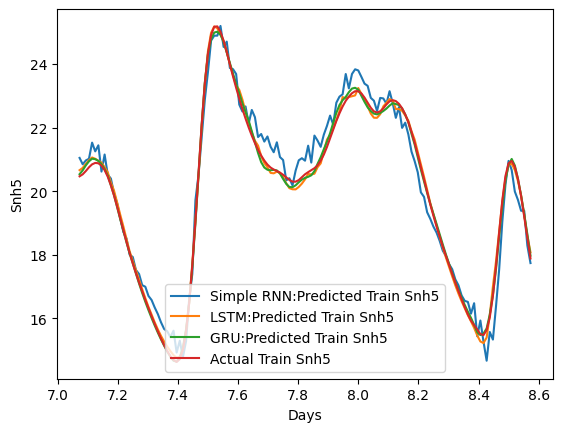

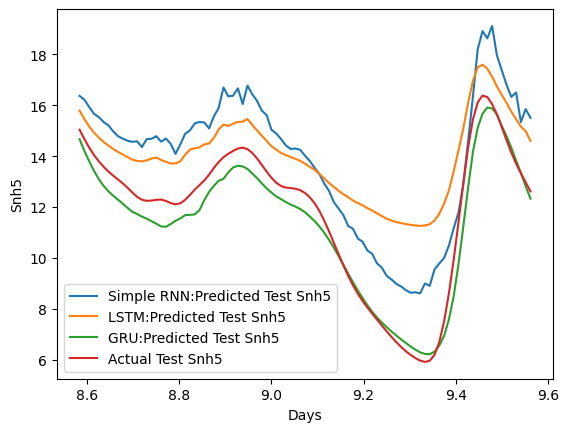

In [ ]:
fig,ax = plt.subplots()
x=df['t']
plt.plot(x[679:824,],model_trainpredictions, label='Simple RNN:Predicted Train Snh5')
plt.plot(x[679:824,],model2_trainpredictions, label='LSTM:Predicted Train Snh5')
plt.plot(x[679:824,],model3_trainpredictions, label='GRU:Predicted Train Snh5')
plt.plot(x[679:824,],actual_trainingset_values, label='Actual Train Snh5')
ax.set_xlabel('Days')
ax.set_ylabel('Snh5')
plt.legend();
plt.show()

fig,ax = plt.subplots()
x=df['t']
plt.plot(x[824:919,],model_predictions, label='Simple RNN:Predicted Test Snh5')
plt.plot(x[824:919,],model2_predictions, label='LSTM:Predicted Test Snh5')
plt.plot(x[824:919,],model3_predictions, label='GRU:Predicted Test Snh5')
plt.plot(x[824:919,],actual_testset_values, label='Actual Test Snh5')
ax.set_xlabel('Days')
ax.set_ylabel('Snh5')
plt.legend();